# Image Classification: Losses and Feature Extraction

Today we'll:

- Look at the images that have the highest loss (does that necessarily mean that the classifier got them wrong?)
- We can explain the importance of good features for neural network models.
- We can explain how the dot product can be interpreted as a similarity measure.

## Setup

In [ ]:
# Check versions of Keras and Tensorflow
!pip list | egrep 'keras|tensorflow '

keras                              3.5.0
keras-core                         0.1.7
keras-cv                           0.9.0
keras-hub                          0.18.1
keras-nlp                          0.18.1
keras-tuner                        1.4.7
tensorflow                         2.17.1
tf_keras                           2.17.0


In [ ]:
import os
# Results are better with the TensorFlow backend; this is probably a bug in Keras 3 but I haven't tracked it down.
os.environ["KERAS_BACKEND"] = "tensorflow"

from IPython.display import display, HTML
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
print(f"Keras version: {keras.__version__}, backend: {keras.backend.backend()}")
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"GPUs: {num_gpus}")
if num_gpus == 0:
    display(HTML("No GPUs available. Training will be slow. <b>Please enable an accelerator.</b>"))

Keras version: 3.5.0, backend: tensorflow
GPUs: 1


In [ ]:
def show_image_grid(images, titles=None, rows=None, cols=3, title_fontsize=8, figsize=(10, 10)):
    if rows is None:
        rows = (len(images) + (cols - 1)) // cols

    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    for ax in axs.flatten(): ax.axis('off')
    for i, ax in enumerate(axs.flatten()):
        if i >= len(images): break
        ax.imshow(np.array(images[i]).astype('uint8'))
        if titles is not None:
            ax.set_title(titles[i], fontsize=title_fontsize)

def get_images_from_dataset(dataset, indices):
    if hasattr(dataset, 'file_paths'):
        # FIXME: hardcoded options
        img_loader_opts = dict(target_size=(256, 256), keep_aspect_ratio=True)
        items_by_idx = {idx: keras.utils.load_img(dataset.file_paths[idx], **img_loader_opts) for idx in indices}
    else:
        items_by_idx = {idx: item for idx, (item, label) in enumerate(dataset.unbatch()) if idx in indices}
    return [items_by_idx[idx] for idx in indices]


## Configure our experiments

In [ ]:
class config:
    seed = 123
    learning_rate = 1e-3
    epochs = 1
    batch_size = 16
    image_size = (256, 256)
    model_preset = "efficientnetv2_b0_imagenet"

In [ ]:
# Reproducibility
# See https://keras.io/examples/keras_recipes/reproducibility_recipes/
#
# Set a seed so that the results are the same every time this is run.
keras.utils.set_random_seed(config.seed)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

### Load the data

We'll use a dataset of flower images for this example, but you can later switch this out for another dataset as long as you keep the file-and-folder structure.

The details of the code in this section are not important at this time; just run these cells.

In [ ]:
path_to_downloaded_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    extract=True,
)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Let's see what just got downloaded.

In [ ]:
data_path = Path(path_to_downloaded_file).parent / 'flower_photos'
!ls {data_path}

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


We'll use a Keras helper function to load the data.

Docs: https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function

In [ ]:
# Define which classes we want to use, in what order.
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Create training and validation datasets
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    labels='inferred',
    class_names=class_names,
    label_mode='int',
    batch_size=config.batch_size,
    image_size=config.image_size,
    shuffle=True,
    seed=128,
    subset='both',
    crop_to_aspect_ratio=True
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


Let's show some example images.

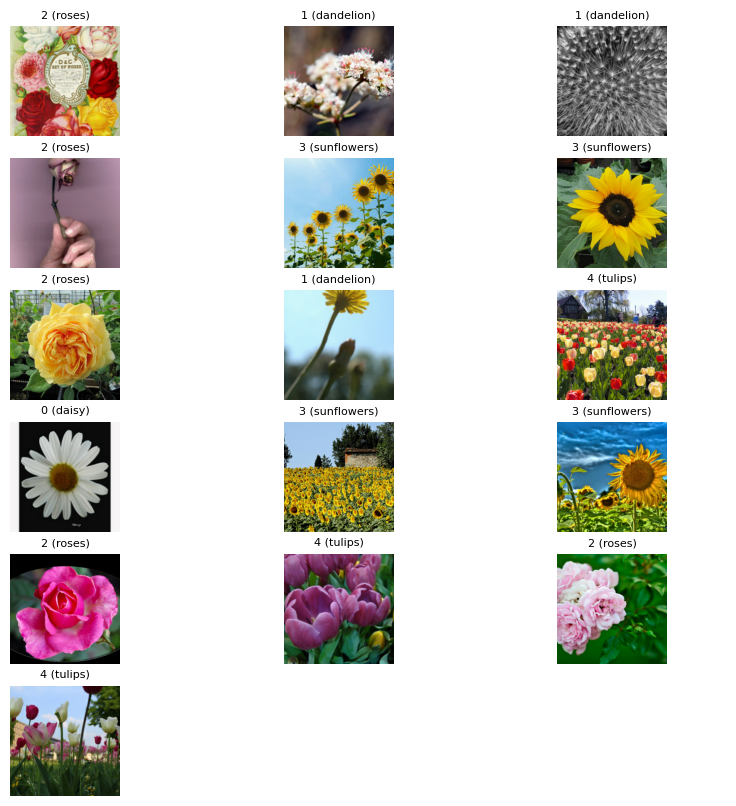

In [ ]:
[[example_images, example_labels]] = train_dataset.take(1)
show_image_grid(
    example_images,
    titles=[f"{label} ({class_names[label]})" for label in example_labels])

### Train a model

In [ ]:
# Create a model using a pretrained backbone
# See https://keras.io/api/keras_cv/models/tasks/image_classifier/ for options
model = keras_cv.models.ImageClassifier.from_preset(
    config.model_preset,
    num_classes=len(class_names))

# Freeze the feature extractor so it doesn't get updated during training
model.backbone.trainable = False

# Set up the model for training
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
    metrics=['accuracy']
)
model.summary(show_trainable=True)

# Train the model. (Note: this may show some warnings, and it may stop without showing
# progress for up to a minute while it translates the model to run on the GPU.)
print("Training the model...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=config.epochs
)

Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, None, None, 3)        │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficient_net_v2b0_backbone         │ (None, None, None, 1280)     │     5,919,312 │    N    │
│ (EfficientNetV2Backbone)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ avg_pool (GlobalAveragePooling2D)   │ (None, 1280)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ predictions (Dense)                 │ (None, 5)                    │         6,405 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 5,925,717 (22.60 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

'Training the model...'

184/184 ━━━━━━━━━━━━━━━━━━━━ 43s 118ms/step - accuracy: 0.6304 - loss: 1.1472 - val_accuracy: 0.8433 - val_loss: 0.5533


## Top Losses

The following code will compute the model's predictions on the validation set and extract the corresponding correct labels. We'll use this to compute the loss for each image.

In [ ]:
val_predicted_probs = model.predict(val_dataset)
val_predicted_probs.shape

46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step


(734, 5)

**Quick Check**: what do the two numbers in that shape mean?

*your answer here*

In [ ]:
# Get the labels from the dataset (to check whether the model got them right)
val_labels = np.array([int(label) for img, label in val_dataset.unbatch()])

In [ ]:
# compute loss for each sample
loss_func = keras.losses.SparseCategoricalCrossentropy(reduction='none')
val_losses = loss_func(val_labels, val_predicted_probs).numpy()

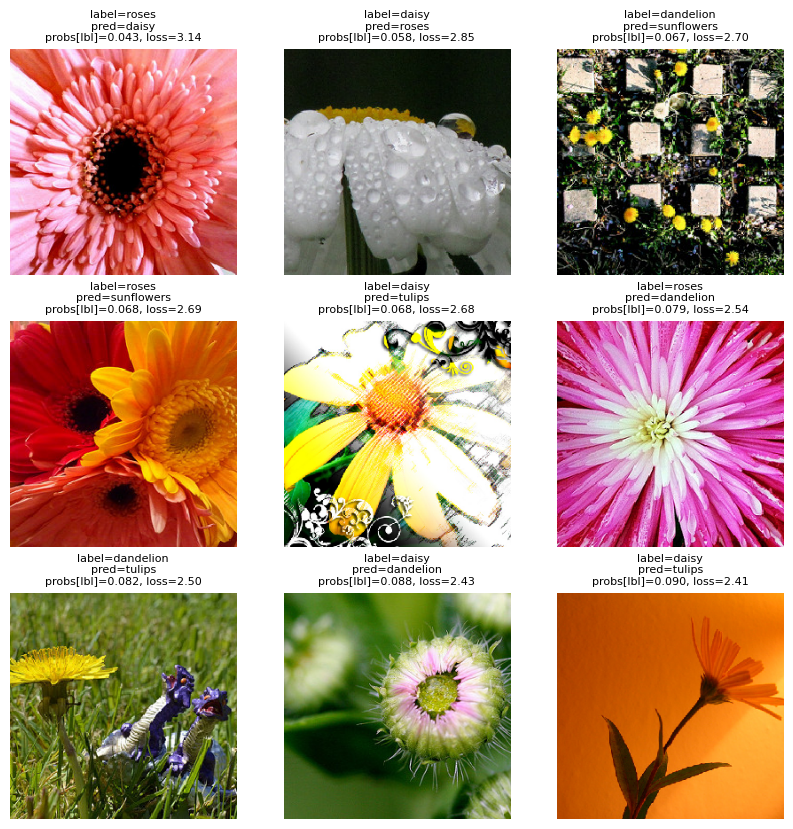

In [ ]:
def plot_top_losses(dataset, predictions, losses, labels, class_names, n=9, **kw):
    top_n_indices = np.argsort(losses)[-n:][::-1].tolist()
    titles = []
    for idx in top_n_indices:
        label = labels[idx]
        pred = predictions[idx]
        titles.append(f"label={class_names[label]}\npred={class_names[np.argmax(pred)]}\nprobs[lbl]={pred[label]:.3f}, loss={losses[idx]:.2f}")
    images = get_images_from_dataset(dataset, top_n_indices)
    show_image_grid(images, titles, **kw)

plot_top_losses(val_dataset, val_predicted_probs, val_losses, val_labels, class_names, n=9)
# To show more:
# plot_top_losses(val_dataset, val_predicted_probs, val_losses, val_labels, class_names, n=100, figsize=(30, 20), cols=10)

**Observations**

1. What trend do you observe about the `loss` values shown above the images, as you move from top left to bottom right? The `loss` values seem to be getting smaller and smaller.
2. What trend do you observe about the `probs[label]` values shown? The `probs[label]` seems to get higher.
3. *added later*: If you know flowers: were the labels correct? Could the loss help us identidy mis-labeled images? The labels are not correct.
4. Compute the cross-entropy loss for the bottom-right image by hand and check if it matches the `loss` value shown. (*Note*: Keras uses log base e, i.e., the "natural" logarithm, called "ln" in some calculators. `math.log` and `np.log` both use this base.) 2.407 ~ 2.41
5. Could an image show up on this grid if it was classified correctly? Why or why not? (Try passing `n=100` and `figsize=(30, 20)` and `cols=6`) yes because it could be very confident in the answer.

*Your answer here*

## Model as Feature Extractor

The following code will compute the outputs of the feature extractor (the input to the last layer of the model) for all of the images in the validation set.

In [ ]:
last_linear_layer = model.layers[-1]
feature_extractor = keras.Model(inputs=model.inputs, outputs=last_linear_layer.input)
val_features = feature_extractor.predict(val_dataset)
print("\nvalidation features shape:", val_features.shape)

46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step

validation features shape: (734, 1280)


**Observe**

1. What do those two numbers in the shape mean?
2. How many features did the feature extractor produce for each image?

*your answer here*

Let's look at three example images, two in the same class and one in a different class

In [ ]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

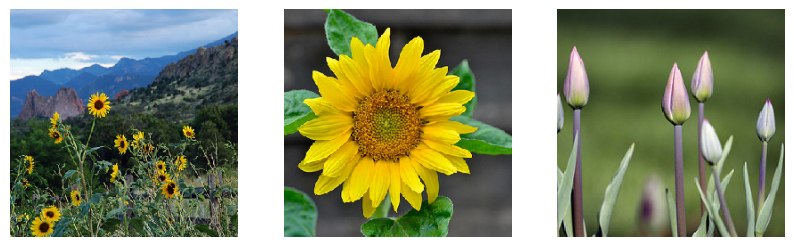

In [ ]:
sunflowers = [idx for idx, label in enumerate(val_labels) if label == 3]
tulips = [idx for idx, label in enumerate(val_labels) if label == 4]
example_image_indices = [sunflowers[0], sunflowers[2], tulips[0]]
show_image_grid(
  get_images_from_dataset(
    val_dataset, example_image_indices))

The model computed a feature vector for each of those images.

In [ ]:
example_features = val_features[example_image_indices]
vec0, vec1, vec2 = example_features
vec0.shape, vec1.shape, vec2.shape

((1280,), (1280,), (1280,))

The dot products between pairs of vectors is a rough measure of similarity: the more two vectors are "in the same direction", the higher their dot product.

In [ ]:
vec0 @ vec1

8.932547

In [ ]:
vec0 @ vec2

7.8749857

In [ ]:
vec1 @ vec2

8.237491

We can look at all pairwise comparisons to get an overview of similarity.

In [ ]:
example_features @ example_features.T

array([[20.29241 ,  8.932544,  7.874987],
       [ 8.932544, 16.889393,  8.237492],
       [ 7.874987,  8.237492, 24.462883]], dtype=float32)

Note that this dot product similarity depends on the magnitude of both vectors: larger vectors will seem more similar to everything else, all else being equal. So we typically normalize by magnitude. (This is called "cosine similarity".) THink about what the maximum and minimum values could be.

In [ ]:
normalized_features = keras.utils.normalize(example_features)
normalized_features @ normalized_features.T

array([[1.0000004 , 0.4825046 , 0.35345092],
       [0.4825046 , 1.        , 0.40526032],
       [0.35345092, 0.40526032, 1.0000001 ]], dtype=float32)

Let's show the images that are most and least similar to the first example image.

In [ ]:
similarity_to_vec0 = keras.utils.normalize(val_features) @ vec0
similarity_to_vec0.shape

(734,)

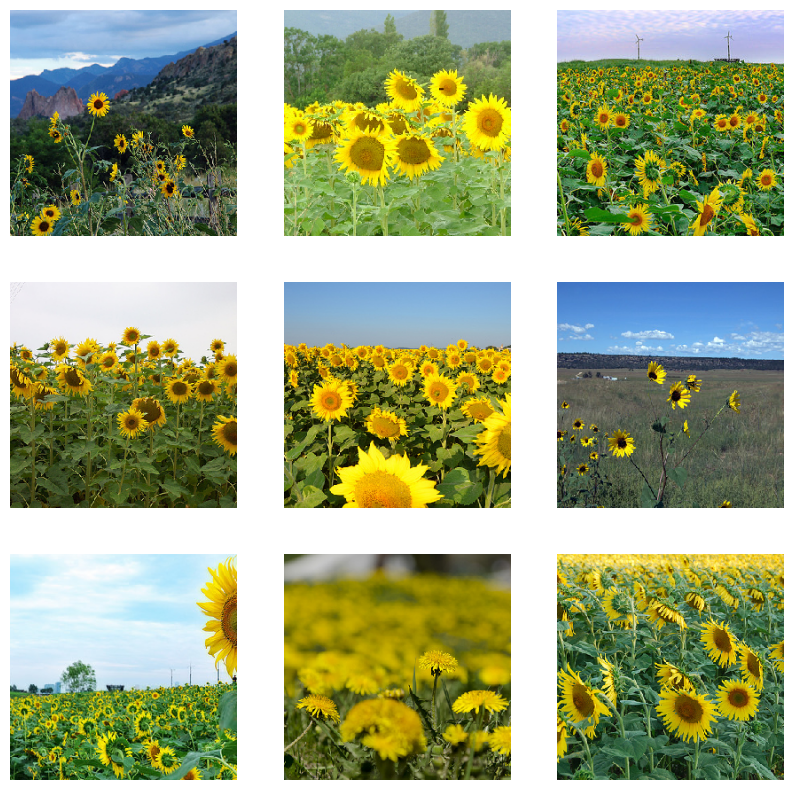

In [ ]:
images_by_similarity = np.argsort(similarity_to_vec0)
show_image_grid(
  get_images_from_dataset(
    val_dataset, images_by_similarity[::-1][:9]))

Exercise: show the *least* similar images (copy-paste the previous code block and just remove something).

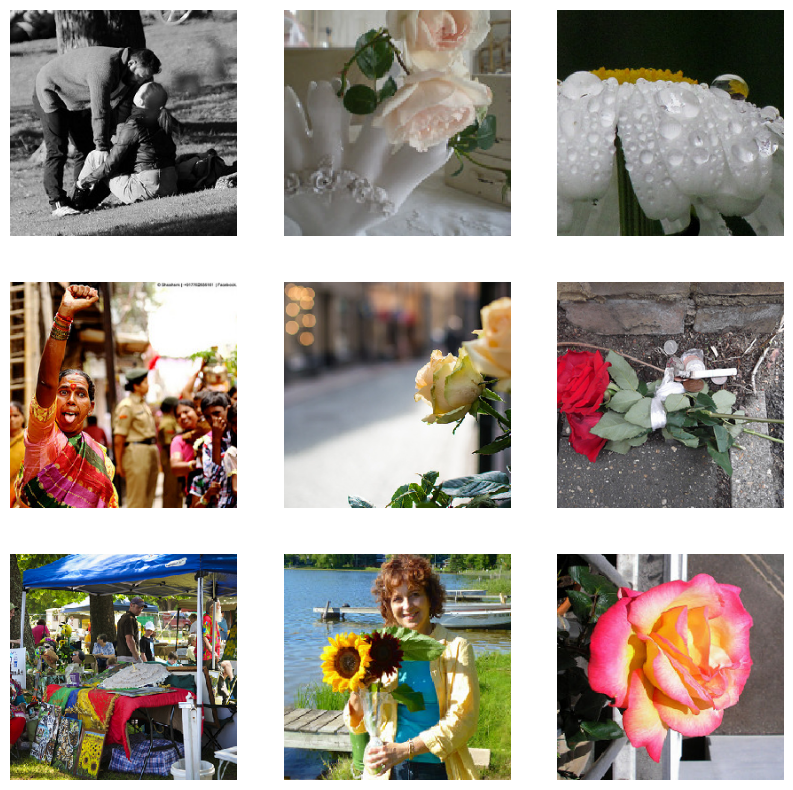

In [ ]:
# your code here

### Importance of Feature Extractors

For contrast, let's look at the similarities in pixel space.

In [ ]:
val_images = np.array([img for img, label in val_dataset.unbatch()])
val_images.shape

(734, 256, 256, 3)

We'll flatten each image into a single big vector.

In [ ]:
val_raw_vecs = val_images.reshape(len(val_images), 256 * 256 * 3)
val_raw_vecs.shape

(734, 196608)

And like before we'll compute similarities.

In [ ]:
first_image_raw_vec = val_raw_vecs[example_image_indices[0]]
similarity_to_first_image_raw = val_raw_vecs @ first_image_raw_vec
similarity_to_first_image_raw.shape

(734,)

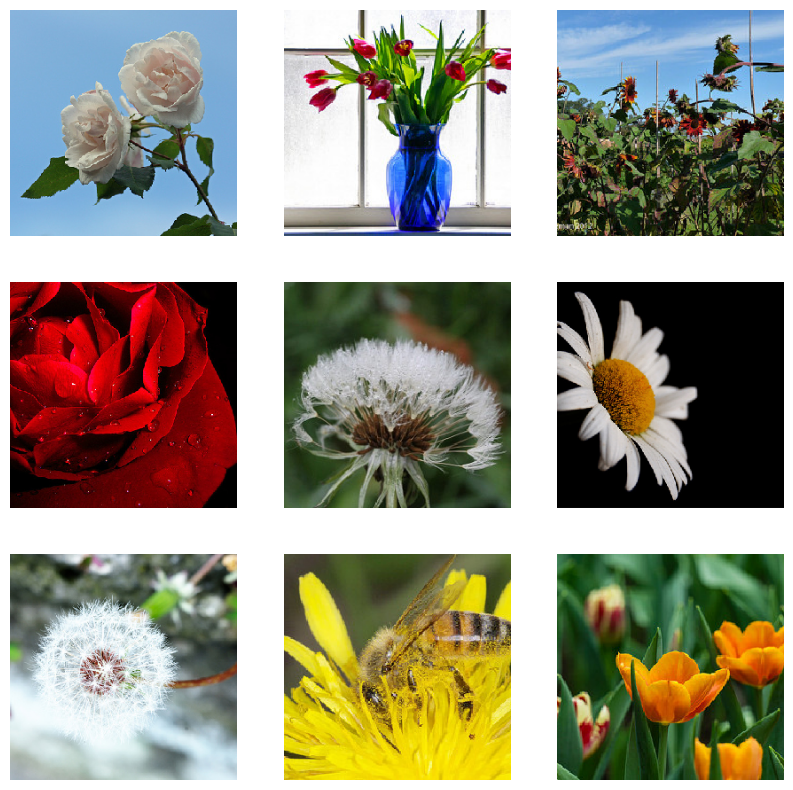

In [ ]:
images_by_similarity = np.argsort(similarity_to_first_image_raw)
show_image_grid(
  get_images_from_dataset(
    val_dataset, images_by_similarity[::-1][:9]))

## Check-In

*These check-in questions were AI-generated*

1. We saw two ways to represent images:
   - Raw pixels (256 * 256 * 3 = 196,608 numbers)
   - Feature vectors (1,280 numbers)
   
   For each representation:

   - What information does it preserve?
   - What information does it discard?
   - When would similarity in this space be (or not be) meaningful?

2. The model makes predictions in three steps:

   - Convert image to feature vector (backbone)
   - Compute similarity with learned patterns (final layer weights)
   - Convert to probabilities (softmax)
   
   For an image that the model misclassifies, which step(s) might have gone wrong? How could you investigate this?

*your thoughtful answers here*